# Overview
For the submission we first run determine whether a picture contains a boat. This is done by using the classification model that has been trained. 
For the images that contain a boat we use the trained instance segmentation U-net to detect boats in the images and classify each pixel. 

# 1. Classification model
Predict whether test images contain a boat

In [26]:
from keras.models import load_model
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
%matplotlib inline

clf_model = load_model("models/ship_classification_model.h5")


In [27]:
import pandas as pd

# import the sample submission csv
sample_submission = pd.read_csv('input/sample_submission.csv')
sample_submission.head()

,ImageId,EncodedPixels
0,0001124c7.jpg,1 2
1,000194a2d.jpg,1 2
2,0001b1832.jpg,1 2
3,00052ed46.jpg,1 2
4,000532683.jpg,1 2


In [28]:
pictures = sample_submission.ImageId.unique()
print('In total there are {} test images'.format(len(pictures)))

In total there are 88486 test images


In [68]:
from tqdm import tqdm_notebook

clf_submission = pd.DataFrame(pictures, columns=['ImageId'])
clf_submission = clf_submission.assign(Prediction=pd.Series([np.NaN for _ in range(len(pictures))]).values)

clf_submission.head()


,ImageId,Prediction
0,0001124c7.jpg,NaN
1,000194a2d.jpg,NaN
2,0001b1832.jpg,NaN
3,00052ed46.jpg,NaN
4,000532683.jpg,NaN


In [70]:
# make prediction for all images
for picture in tqdm_notebook(pictures[:100]):
    img_path = os.path.join('input/test', picture)
    img = mpimg.imread(img_path)
    img = np.expand_dims(img, axis=0)
    pred = clf_model.predict(img)[0][0]
    if pred < 0.5:
        # add 0 to image
        clf_submission.loc[clf_submission.index[clf_submission.ImageId == picture], 'Prediction'] = 0
    else:
        # add 1 to image
        clf_submission.loc[clf_submission.index[clf_submission.ImageId == picture], 'Prediction'] = 1



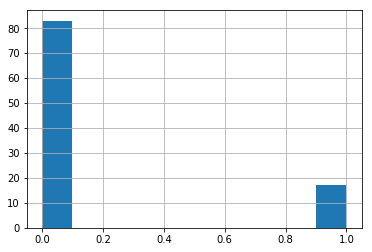

In [72]:
clf_submission.Prediction.hist()


We determined the images that do not contain boats. Now we can have a look at the images that, according to our classification model, do contain boats. For these images we use the previously trained object detection model to classify each pixel. 

In [74]:
clf_submission['Prediction'] = clf_submission['Prediction'].map(lambda x: np.NaN if x == 0 else x)
is_boat = clf_submission.Prediction.notnull()
clf_submission.head()


,ImageId,Prediction
0,0001124c7.jpg,NaN
1,000194a2d.jpg,NaN
2,0001b1832.jpg,NaN
3,00052ed46.jpg,NaN
4,000532683.jpg,1.0


In [85]:
import keras.backend as K
from keras.losses import binary_crossentropy

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    return K.mean((2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    return 1e-3 * binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true) * K.flatten(K.round(y_pred))) / K.sum(y_true)

def IoU(y_true, y_pred, eps=1e-6):
    if np.max(y_true) == 0.0:
        return IoU(1 - y_true, 1 - y_pred)  ## empty image; calc IoU of zeros
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    return -K.mean((intersection + eps) / (union + eps), axis=0)


seg_model = load_model("models/segmentation_model_final_v1.h5",
                   custom_objects={'dice_p_bce': dice_p_bce, 'dice_coef': dice_coef,

                                   'true_positive_rate': true_positive_rate,
                                   'IoU': IoU})


In [92]:
def predict(img):
    img_path = os.path.join('input/test', img)
    img = mpimg.imread(img_path)
    img = np.expand_dims(img, axis=0)
    pred = seg_model.predict(img)[0]
    pred = binary_opening(pred > 0.99, np.expand_dims(disk(2), -1))
    pred = remove_small_objects(pred, connectivity=2)
    return pred, img


In [93]:
from skimage.segmentation import mark_boundaries
from skimage.morphology import binary_opening, disk, label, remove_small_objects

out_pred_rows = list()
for picture in clf_submission.ImageId[is_boat]:
    pred, img = predict(picture)
    labels = label(pred)
    print(labels)


[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]


[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]


KeyboardInterrupt: 